## [High-dimensional Bayesian workflow, with applications to SARS-CoV-2 strains](http://pyro.ai/examples/workflow.html#High-dimensional-Bayesian-workflow,-with-applications-to-SARS-CoV-2-strains)

#### The fastest way to find a good model of your data is to quickly discard many bad models, i.e. to iterate. In statistics we call this iterative workflow Box’s loop. 
#### An efficient workflow allows us to discard bad models as quickly as possible. Workflow efficiency demands that code changes to upstream components don’t break previous coding effort on downstream components. 
#### Pyro’s approaches to this challenge include strategies for variational approximations (pyro.infer.autoguide) and strategies for transforming model coordinate systems to improve geometry (pyro.infer.reparam

1. Clean the data.

2. Create a generative model.

3. Sanity check using MAP or mean-field inference.

4. Create an initialization heuristic.

5. Reparameterize the model, evaluating results under mean field VI.

6. Customize the variational family (autoguides, easyguides, custom guides).

##### The model is a high-dimensional regression model with around 1000 coefficients, a multivariate logistic growth function (using a simple torch.softmax()) and a Multinomial likelihood. While the number of coefficients is relatively small, there are about 500,000 local latent variables to estimate, and plate structure in the model should lead to an approximately block diagonal posterior covariance matrix

In [1]:
from collections import defaultdict
from pprint import pprint
import functools
import math
import os

In [2]:
import torch
import pyro

In [3]:
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions import constraints
from pyro.infer import SVI, Trace_ELBO

In [4]:
from pyro.infer.autoguide import (
    AutoDelta,
    AutoNormal,
    AutoMultivariateNormal,
    AutoLowRankMultivariateNormal,
    AutoGuideList,
    init_to_feasible
)

In [5]:
from pyro.infer.reparam import AutoReparam, LocScaleReparam

In [6]:
from pyro.nn.module import PyroParam

In [7]:
from pyro.optim import ClippedAdam

In [8]:
from pyro.ops.special import sparse_multinomial_likelihood

In [9]:
import matplotlib.pyplot as plt

In [10]:
if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
else:
    pass

___

In [11]:
from pyro.contrib.examples.nextstrain import load_nextstrain_counts

In [12]:
data_set = load_nextstrain_counts()

In [13]:
isinstance(data_set, dict)

True

In [14]:
for k, v in data_set.items():
    print(k, type(v))

start_date <class 'datetime.datetime'>
time_step_days <class 'int'>
locations <class 'list'>
lineages <class 'list'>
mutations <class 'list'>
features <class 'torch.Tensor'>
counts <class 'torch.Tensor'>
sparse_counts <class 'dict'>


In [15]:
isinstance(data_set, torch.Tensor)

False

#### The first step to using Pyro is creating a generative model, either a python function or a pyro.nn.Module. Start simple. Start with a shallow hierarchy and later add latent variables to share statistical strength. Start with a slice of your data then add a plate over multiple slices. Start with simple distributions like Normal, LogNormal, Poisson and Multinomial, then consider overdispersed versions like StudentT, Gamma, GammaPoisson/NegativeBinomial, and DirichletMultinomial. Keep your model simple and readable so you can share it and get feedback from domain experts. Use weakly informative priors.

#### Note we scale coef by 1/100 because we want to model a very small number, but the automatic parts of Pyro and PyTorch work best for numbers on the **order of 1.0 rather than very small numbers**. When we later interpret coef in a volcano plot we’ll need to duplicate this scaling factor.

In [16]:
data_set.keys()

dict_keys(['start_date', 'time_step_days', 'locations', 'lineages', 'mutations', 'features', 'counts', 'sparse_counts'])

In [17]:
data_set['counts'].numel()

7177464

In [18]:
data_set['counts'].count_nonzero()

tensor(57129)

In [19]:
data_set['time_step_days']

28

In [20]:
data_set['features'].shape

torch.Size([1316, 2634])

In [21]:
data_set['counts'].shape

torch.Size([27, 202, 1316])

In [22]:
def model(data_set):
    features = data_set['features']
    counts = data_set['counts']

    assert features.shape[0] == counts.shape[-1]
    S, M = features.shape # 1316, 2634 mutations
    T, P, S = counts.shape # 27 time, 202 places, 1326 clusters/strain

    time = torch.arange(float(T)) * data_set['time_step_days'] / 5.5
    time -= time.mean()

    strain_plate = pyro.plate("strain", S, dim = -1)
    place_plate = pyro.plate("place", P, dim= -2)
    time_plate = pyro.plate("time", T, dim = -3)

    rate_scale = pyro.sample("rate_scale", dist.LogNormal(-4,2))
    init_sacle = pyro.sample('init_scale', dist.LogNormal(0, 2))

    with pyro.plate("mutation", M, dim = -1):
        coef = pyro.sample('coef', dist.Laplace(0,0.5))

    with strain_plate:
        rate_loc = pyro.deterministic("rate_loc", 0.01 * coef @ features.T) 
    
    with place_plate, strain_plate:
        rate = pyro.sample("rate", dist.Normal(rate_loc, rate_scale))
        init = pyro.sample("init", dist.Normal(0, init_sacle))

    logits = init + rate * time[:, None, None]

    with time_plate, place_plate:
        pyro.sample(
            "obs",
            dist.Multinomial(logits=logits.unsqueeze(-2), validate_args=False),
            obs = counts.unsqueeze(-2),
        )

In [23]:
def model(data_set, predict=None):
    features = data_set["features"]
    counts = data_set["counts"]
    sparse_counts = data_set["sparse_counts"]
    assert features.shape[0] == counts.shape[-1]
    S, M = features.shape # 1316, 2634 mutations
    T, P, S = counts.shape # 27 time, 202 places, 1326 clusters/strain

    time = torch.arange(float(T)) * data_set['time_step_days'] / 5.5
    time -= time.mean()

    rate_scale = pyro.sample("rate_scale", dist.LogNormal(-4,2))
    init_sacle = pyro.sample('init_scale', dist.LogNormal(0, 2))

    with pyro.plate("mutation", M, dim = -1):
        coef = pyro.sample('coef', dist.Laplace(0,0.5))

    with pyro.plate("strain", S, dim=-1):
        rate_loc = pyro.deterministic("rate_loc", 0.01 * coef @ features.T)
        with pyro.plate("place", P, dim=-2):
            rate = pyro.sample("rate", dist.Normal(rate_loc, rate_scale))
            init = pyro.sample("init", dist.Normal(0, init_sacle))
    if predict is not None:
        probs = (init+rate * time[predict]).softmax(-1)
        return probs

    logits = (init + rate * time[:, None, None]).log_softmax(-1)

    t,p,s = sparse_counts['index']

    pyro.factor(
        "obs",
        sparse_multinomial_likelihood(
            sparse_counts["total"], logits[t,p,s], sparse_counts["value"]
        )
    )


In [24]:
def fit_svi(model, guide, lr=0.01, num_steps = 1001, log_every = 100, plot=True):
    pyro.clear_param_store()
    pyro.set_rng_seed(20221114)

    num_latents = sum(
        site['value'].numel()
        for name, site in poutine.trace(guide).get_trace(data_set).iter_stochastic_nodes()
        if not site['infer'].get("is_auxiliary")
    )

    num_params = sum(
        p.unconstrained().numel() for p in pyro.get_param_store().values()
    )

    print(f"found {num_latents} latent variables and {num_params} learnable parameters")

    series =  defaultdict(list)
    def hook(g, series):
        series.append(torch.linalg.norm(g.reshape(-1), math.inf).item())
    for name, value in pyro.get_param_store().named_parameters():
        value.register_hook(
            functools.partial(hook, series=series[name+" grad"])
        )
    
    optim = ClippedAdam({"lr": lr, "lrd": 0.1 ** (1/num_steps)})

    svi = SVI(model, guide, optim, Trace_ELBO())

    num_obs = int(data_set['counts'].count_nonzero())

    for step in range(num_steps):
        loss = svi.step(data_set) / num_obs
        series["loss"].append(loss)
        median = guide.median()
        for name, value in median.items():
            if value.numel() == 1:
                series[name+" mean"].append(float(value))
        if step % log_every == 0:
            print(f"step {step: >4d} loss= {loss:0.6g}")

    if plot:
        plt.figure(figsize=(18,12))
        for name, Y in series.items():
            if name == "loss":
                plt.plot(Y, "k--", label=name, zorder =0)
            elif name.endswith("mean"):
                plt.plot(Y, label=name, zorder=-1)
            else:
                plt.plot(Y, label=name, alpha=0.5, lw=1, zorder=-2)
        plt.yscale("log")
        plt.xscale("symlog")
        plt.xlim(0, None)
        plt.legend(loc="best", fontsize=8)
        plt.tight_layout()

found 538452 latent variables and 1068600 learnable parameters
step    0 loss= 267.617
step  100 loss= 63.3224
step  200 loss= 44.621
step  300 loss= 34.7868
step  400 loss= 30.4325
step  500 loss= 27.5609
step  600 loss= 25.4607
step  700 loss= 23.8854
step  800 loss= 22.7713
step  900 loss= 21.8865
step 1000 loss= 21.24
CPU times: user 4min 23s, sys: 14.1 s, total: 4min 37s
Wall time: 1min 13s


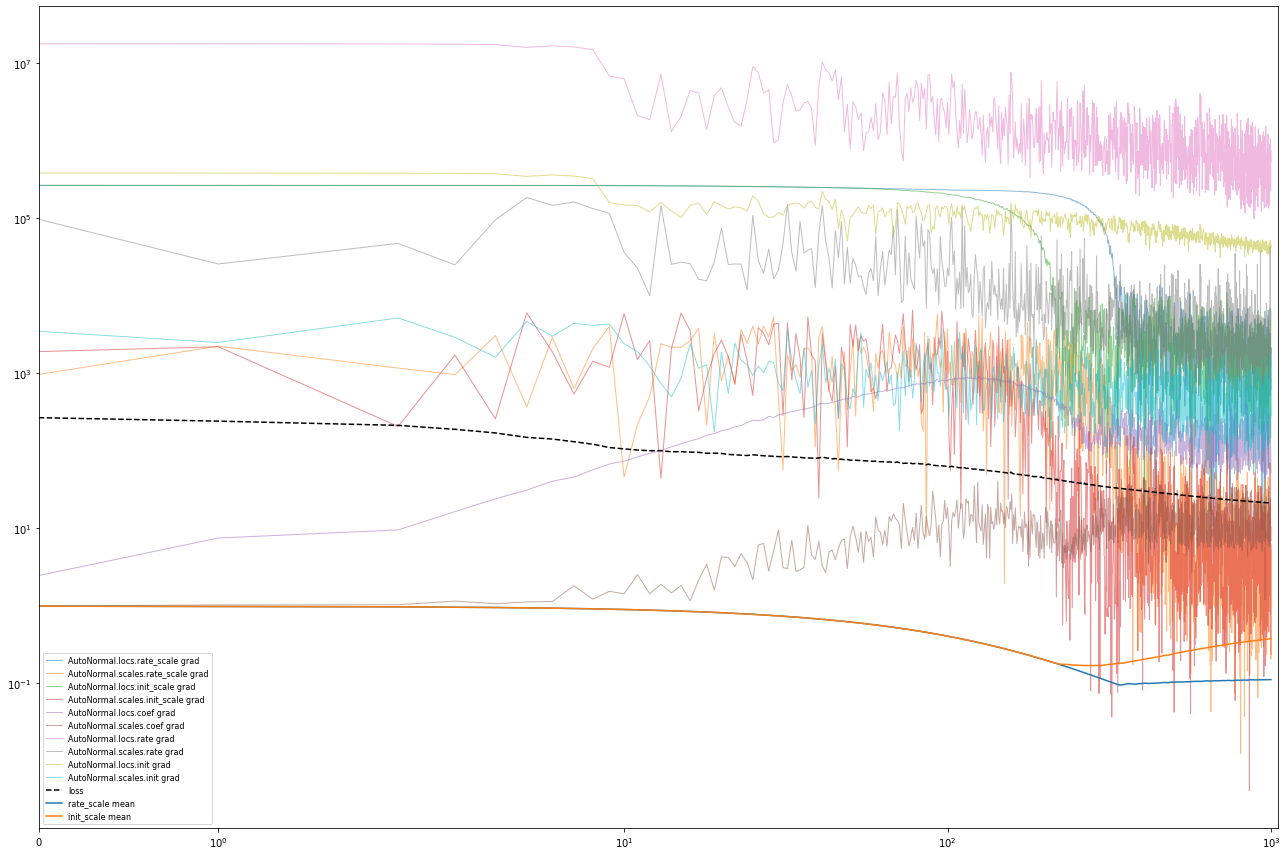

In [25]:
%%time
guide = AutoNormal(model, init_scale=0.01)
fit_svi(model, guide)

### [Tutorial Code](https://github.com/pyro-ppl/pyro/blob/dev/tutorial/source/logistic-growth.ipynb)

##### After each change to the model or inference, you’ll validate model outputs, closing Box’s loop. In our running example we’ll quantitiatively evaluate using the mean average error (MAE) over the last fully-observed time step.

 ### [Paper code](https://github.com/broadinstitute/pyro-cov)

In [26]:
def mae(true_counts, pred_probs):
    pred_counts = pred_probs * true_counts.sum(-1, True)
    error = (true_counts - pred_counts).abs().sum(-1)
    total = true_counts.sum(-1).clamp(min=1)
    return (error / total).mean().item()

In [27]:
def evaluate(model, guide, num_particles=100, location="USA / Massachusetts", time=-2):
    with torch.no_grad(), poutine.mask(mask=False):
        with pyro.plate("particle", num_particles, dim=-3):
            guide_trace = poutine.trace(guide).get_trace(data_set)
            probs = poutine.replay(model, guide_trace)(data_set, predict=time)
        probs = probs.squeeze().mean(0) # average over MC samples
        true_counts = data_set['counts'][time]

        global_mae = mae(true_counts, probs)
        i = data_set['locations'].index(location)
        local_mae = mae(true_counts[i], probs[i])
    return {"MAE (global)":global_mae, f"MAE ({location})": local_mae}

In [28]:
evaluate(model, guide)

{'MAE (global)': 0.22228437662124634,
 'MAE (USA / Massachusetts)': 0.22930532693862915}

##### We’ll also qualitatively evaluate using a volcano plot showing the effect size and statistical significance of each mutation’s coefficient, and labeling the mutation with the most significant positive effect. We expect: - most mutations have very little effect (they are near zero in log space, so their multiplicative effect is near 1x) - more mutations have positive effect than netagive effect - effect sizes are on the order of 1.1 or 0.9.

In [29]:
def plot_volcano(guide, num_particles=100):
    with torch.no_grad(), poutine.mask(mask=False):  # makes computations cheaper
        with pyro.plate("particle", num_particles, dim=-3):  # vectorizes
            trace = poutine.trace(guide).get_trace(data_set)
            trace = poutine.trace(poutine.replay(model, trace)).get_trace(data_set, -1) # model(dataset, predict=-1)
            coef = trace.nodes["coef"]["value"].cpu()
    coef = coef.squeeze() * 0.01  # Scale factor as in the model.
    mean = coef.mean(0)
    std = coef.std(0)
    z_score = mean.abs() / std
    effect_size = mean.exp().numpy()
    plt.figure(figsize=(16, 13))
    plt.scatter(effect_size, z_score.numpy(), lw=0, s=5, alpha=0.5, color="darkred")
    plt.yscale("symlog")
    plt.ylim(0, None)
    plt.xlabel("$R_m/R_{wt}$")
    plt.ylabel("z-score")
    i = int((mean / std).max(0).indices)
    plt.text(effect_size[i], z_score[i] * 1.1, data_set["mutations"][i], ha="center", fontsize=8)
    plt.title(f"Volcano plot of {len(mean)} mutations")

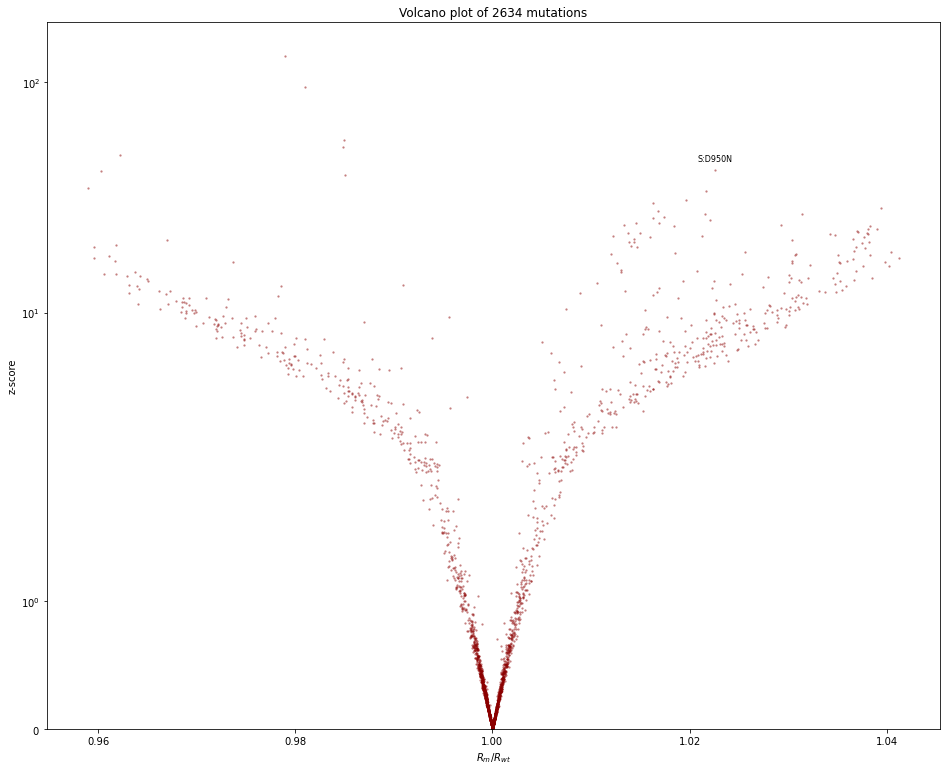

In [30]:
plot_volcano(guide)

### [Create an initialization heuristic](http://pyro.ai/examples/workflow.html#Create-an-initialization-heuristic)

##### In high-dimensional models, convergence can be slow and NANs arise easily, even when sampling from weakly informative priors. We recommend heuristically initializing a point estimate for each latent variable, aiming to initialize at something that is the right order of magnitude. Often you can initialize to a simple statistic of the data, e.g. a mean or standard deviation.

In [31]:
def init_loc_fn(site):
    shape = site["fn"].shape()
    if site["name"] == "coef":
        return torch.randn(shape).sub_(0.5).mul(0.01)
    if site["name"] == "init":
        return data_set["counts"].mean(0).add(0.01).log()
    return init_to_feasible(site)


##### As you evolve a model, you’ll add and remove and rename latent variables. We find it useful to require inits for all latent variables, add a message to remind yourself to udpate the init_loc_fn whenever the model changes.

In [32]:
def init_loc_fn(site):
    shape = site["fn"].shape()
    if site["name"].endswith("_scale"):
        return torch.ones(shape)
    if site["name"] == "coef":
        return torch.randn(shape).sub_(0.5).mul(0.01)
    if site["name"] == "init":
        return data_set["counts"].mean(0).add(0.01).log()
    if site['name'] == "rate":
        return torch.zeros(shape)
    raise NotImplementedError(f"TODO initialize latent variable {site['name']}")

found 538452 latent variables and 1068600 learnable parameters
step    0 loss= 128.372
step  100 loss= 44.6291
step  200 loss= 32.2055
step  300 loss= 24.7074
step  400 loss= 20.4324
step  500 loss= 19.1091
step  600 loss= 17.3997
step  700 loss= 16.1231
step  800 loss= 16.2522
step  900 loss= 15.4683
step 1000 loss= 15.3406
CPU times: user 4min 18s, sys: 12.3 s, total: 4min 30s
Wall time: 1min 11s


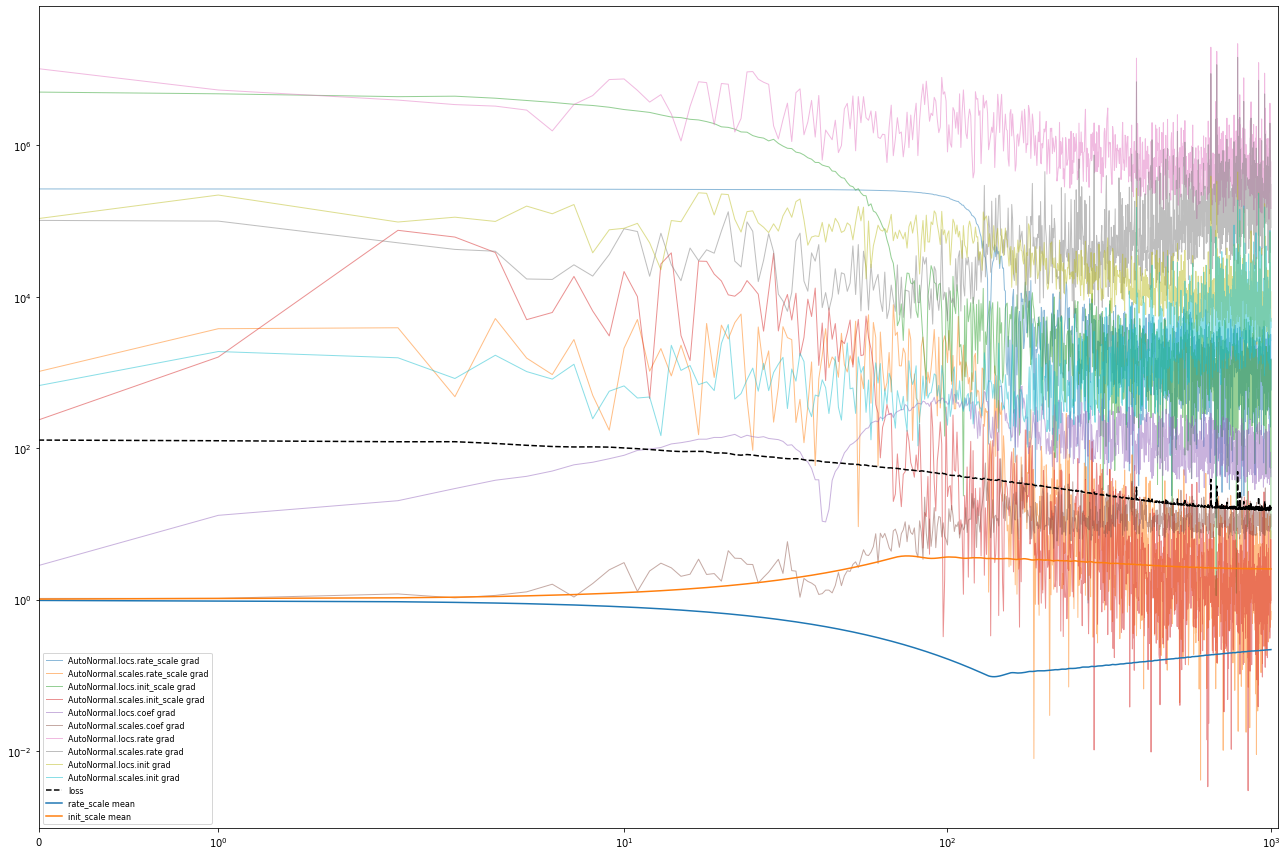

In [33]:
%%time
guide = AutoNormal(model, init_loc_fn = init_loc_fn, init_scale = 0.01)
fit_svi(model, guide, lr=0.02)

In [34]:
evaluate(model, guide)

{'MAE (global)': 0.2290789932012558,
 'MAE (USA / Massachusetts)': 0.3072933256626129}

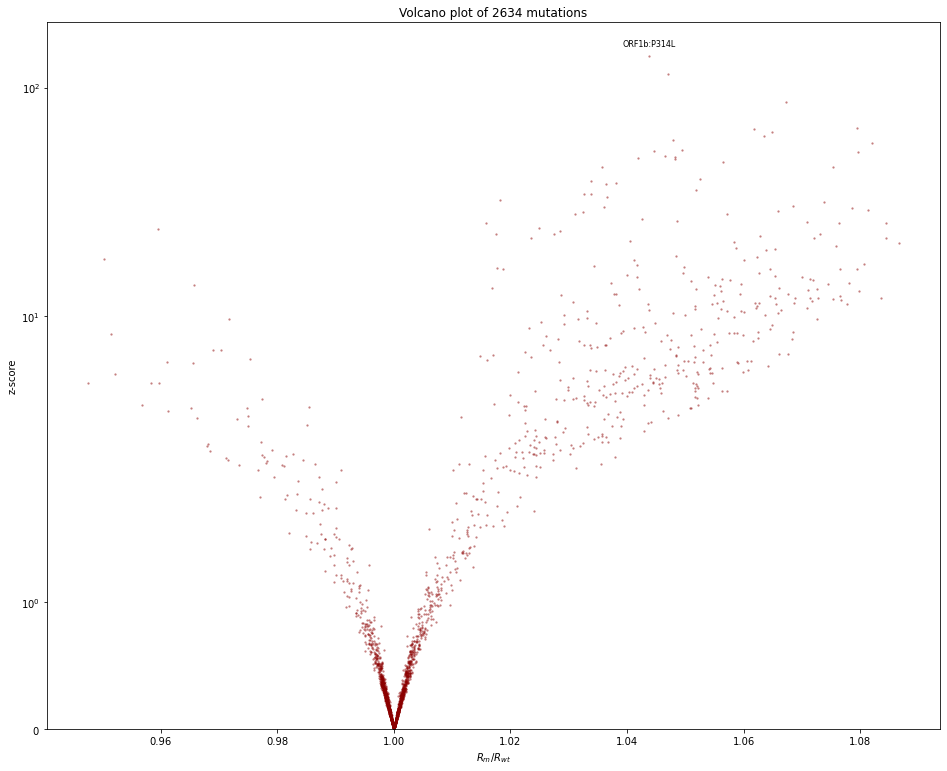

In [35]:
plot_volcano(guide)

### [Reparametrize the model](http://pyro.ai/examples/workflow.html#Reparametrize-the-model)

##### Reparametrizing a model preserves its distribution while changing its geometry. Reparametrizing is simply a change of coordinates. When reparametrizing we aim to warp a model’s geometry to remove correlations and to lift inconvenient topological manifolds into simpler higher dimensional flat Euclidean space.

##### Whereas many probabilistic programming languages require users to rewrite models to change coordinates, Pyro implements a library of about 15 different reparametrization effects including decentering (Gorinova et al. 2020), Haar wavelet transforms, and neural transport (Hoffman et al. 2019), as well as strategies to automatically apply effects and machinery to create custom reparametrization effects. Using these reparametrizers you can separate modeling from inference: first specify a model in a form that is natural to domain experts, then in inference code, reparametrize the model to have geometry that is more amenable to variational inference.

found 538452 latent variables and 1068602 learnable parameters
step    0 loss= 128.326
step  100 loss= 19.8789
step  200 loss= 11.1637
step  300 loss= 10.2876
step  400 loss= 9.78468
step  500 loss= 9.27561
step  600 loss= 8.80521
step  700 loss= 8.81774
step  800 loss= 8.69403
step  900 loss= 8.82198
step 1000 loss= 8.668
CPU times: user 5min 44s, sys: 14.2 s, total: 5min 58s
Wall time: 1min 32s


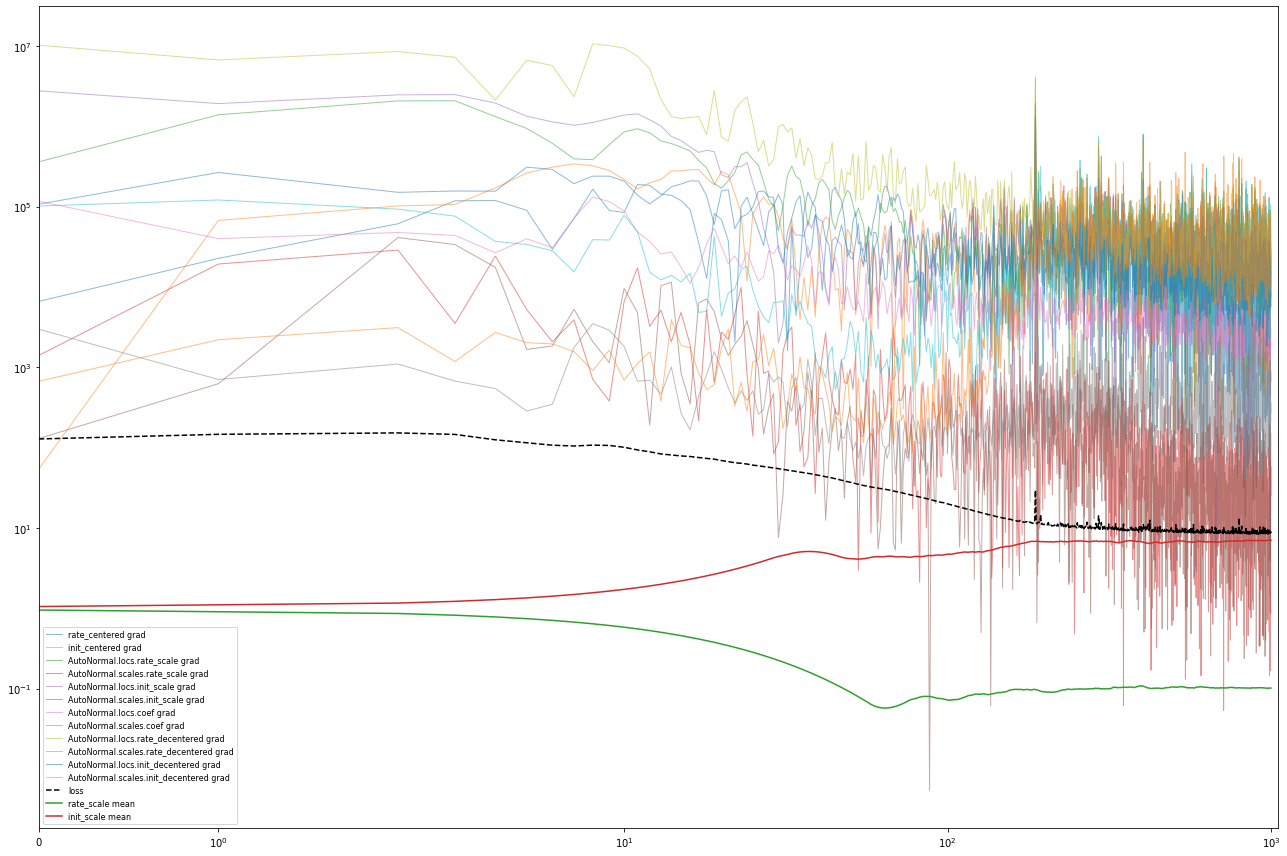

In [36]:
%%time
reparam_model = poutine.reparam(
    model,
    {
        "rate": LocScaleReparam(),
        "init": LocScaleReparam()
    }
)

guide = AutoNormal(reparam_model, init_loc_fn=init_loc_fn, init_scale=0.01)
fit_svi(reparam_model, guide, lr=0.05)

In [37]:
evaluate(model, guide)

{'MAE (global)': 0.6934912800788879,
 'MAE (USA / Massachusetts)': 1.4621458053588867}

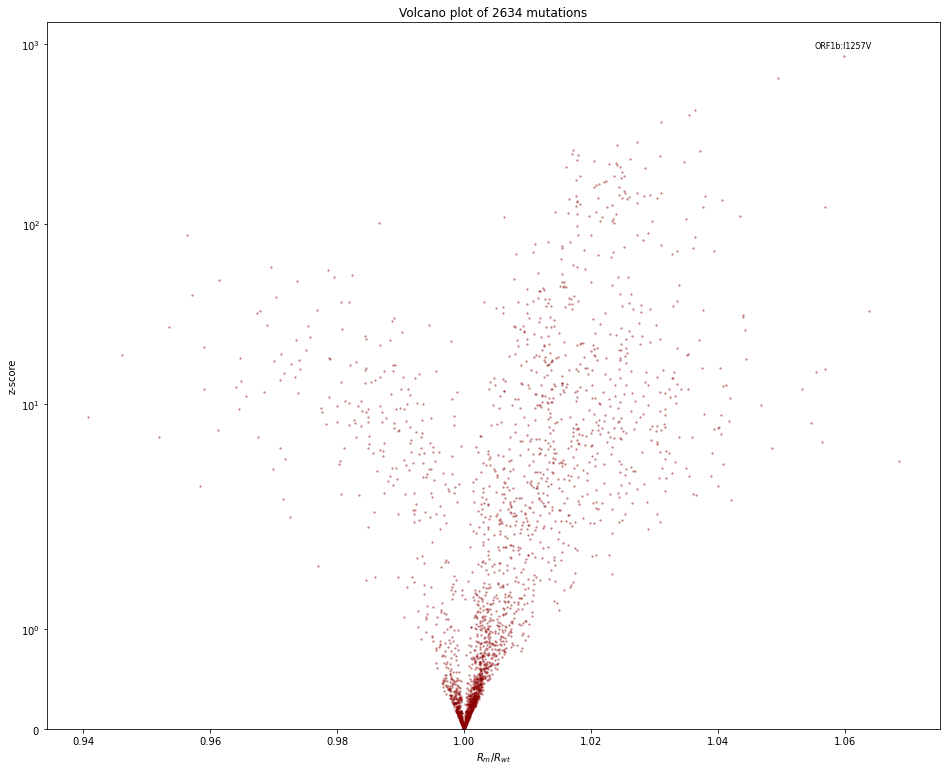

In [38]:
plot_volcano(guide)

### [Customize the variational family](http://pyro.ai/examples/workflow.html#Customize-the-variational-family)

##### When creating a new model, we recommend starting with mean field variational inference using an `AutoNormal <>`__ guide. This mean field guide is good at finding the neighborhood of your model’s mode, but naively it ignores correlations between latent variables. A first step in capturing correlations is to reparametrize the model as above: using a LocScaleReparam or HaarReparam (where appropriate) already allows the guide to capture some correlations among latent variables.

1. Start with an `AutoNormal <>`__ guide. 
2. Try `AutoLowRankMultivariateNormal <>`, which can model the principle components of correlated uncertainty. (For models with only ~100 latent variables you might also try `AutoMultivariateNormal <>`__ or `AutoGaussian <>`__). 
3. Try combining multiple guides using `AutoGuideList <>`. For example if `AutoLowRankMultivariateNormal <>`__ is too expensive for all the latent variables, you can use `AutoGuideList <>`__ to combine an `AutoLowRankMultivariateNormal <>`__ guide over a few top-level global latent variables, together with a cheaper `AutoNormal <>`__ guide over more numerous local latent variables. 
4. Try using `AutoGuideList <>`__ to combine a autoguide together with a custom guide function built using pyro.sample, pyro.param, and pyro.plate. Given a partial_guide() function that covers just a few latent variables, you can AutoGuideList.append(partial_guide) just as you append autoguides. 
5. Consider customizing one of Pyro’s autoguides that leverage model structure, e.g. AutoStructured, AutoNormalMessenger, AutoHierarchicalNormalMessenger AutoRegressiveMessenger. 
6. For models with local correlations, consider building on EasyGuide, a framework for building guides over groups of variables.

#### The author recommends avoiding completely low-level guides and instead using AutoGuide or EasyGuide for at least some parts of the model, thereby speeding up model iteration.

In [39]:
%%time
reparam_model = poutine.reparam(
    model,
    {
        "rate": LocScaleReparam(),
        "init": LocScaleReparam()
    }
)

guide = AutoLowRankMultivariateNormal(
    reparam_model, init_loc_fn=init_loc_fn, init_scale = 0.01, rank = 100
)

fit_svi(reparam_model, guide, num_steps=100, log_every=10, plot=False)

found 538452 latent variables and 54498602 learnable parameters
step    0 loss= 131.067
step   10 loss= 115.427
step   20 loss= 107.031
step   30 loss= 103.63
step   40 loss= 99.4521
step   50 loss= 99.2647
step   60 loss= 95.1097
step   70 loss= 94.0267
step   80 loss= 92.3246
step   90 loss= 90.8973
CPU times: user 8min 27s, sys: 1min 46s, total: 10min 14s
Wall time: 2min 37s


found 538452 latent variables and 1202987 learnable parameters
step    0 loss= 4435.91
step  100 loss= 12.5802
step  200 loss= 11.0212
step  300 loss= 11.1724
step  400 loss= 9.73845
step  500 loss= 10.5884
step  600 loss= 9.474
step  700 loss= 9.26569
step  800 loss= 10.2911
step  900 loss= 9.28805
step 1000 loss= 9.29655
CPU times: user 6min 10s, sys: 13.8 s, total: 6min 24s
Wall time: 1min 39s


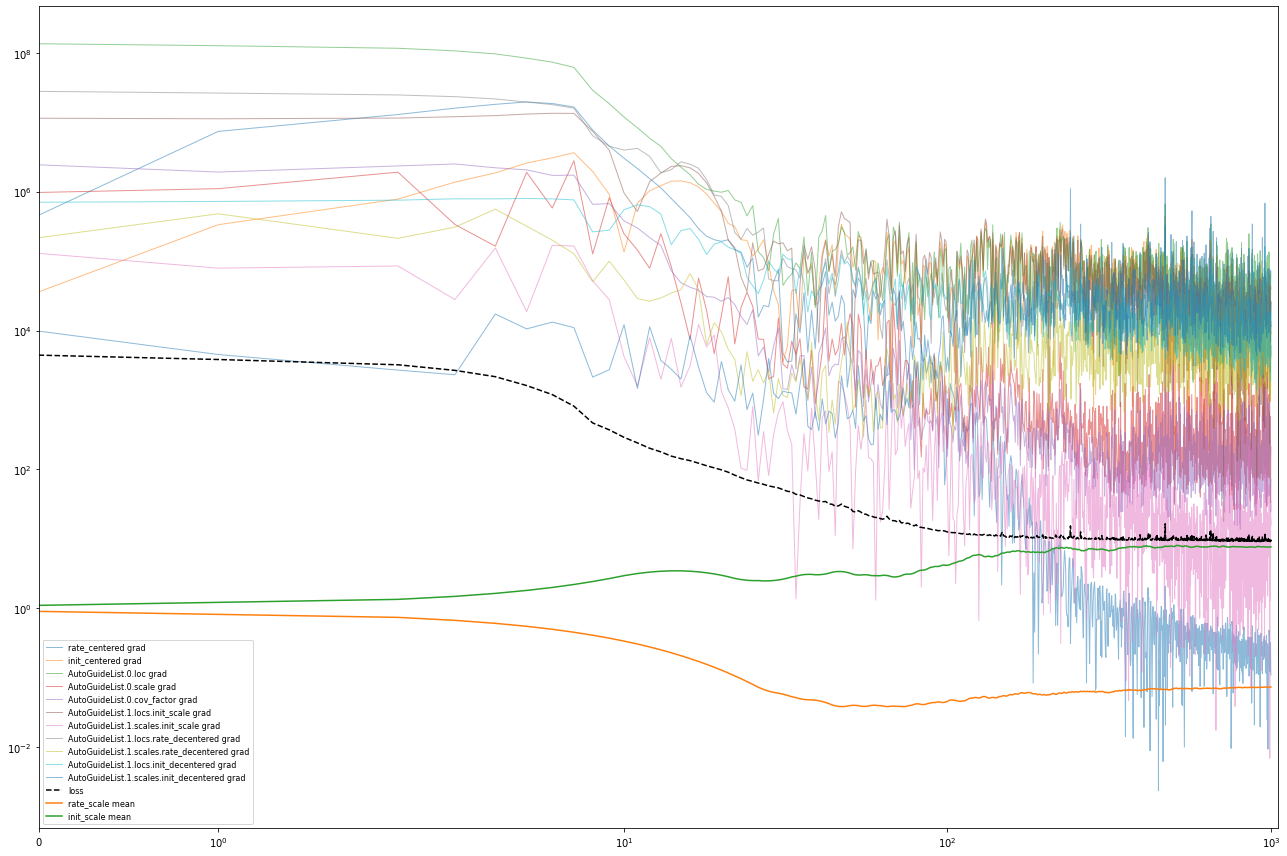

In [40]:
%%time
reparam_model = poutine.reparam(
    model,
    {
        "rate": LocScaleReparam(),
        "init": LocScaleReparam()
    }
)

guide = AutoGuideList(reparam_model)
mvn_vars = ["coef", "rate_scale", "coef_scale"]
guide.add(
    AutoLowRankMultivariateNormal(
        poutine.block(reparam_model, expose= mvn_vars),
        init_loc_fn=init_loc_fn,
        init_scale = 0.01
    )
)

guide.add(
    AutoNormal(
        poutine.block(reparam_model, hide=mvn_vars),
        init_loc_fn=init_loc_fn,
        init_scale = 0.01
    )
)

fit_svi(reparam_model, guide, lr=0.1)

In [41]:
evaluate(reparam_model, guide)

{'MAE (global)': 0.17154540121555328,
 'MAE (USA / Massachusetts)': 0.1032305657863617}

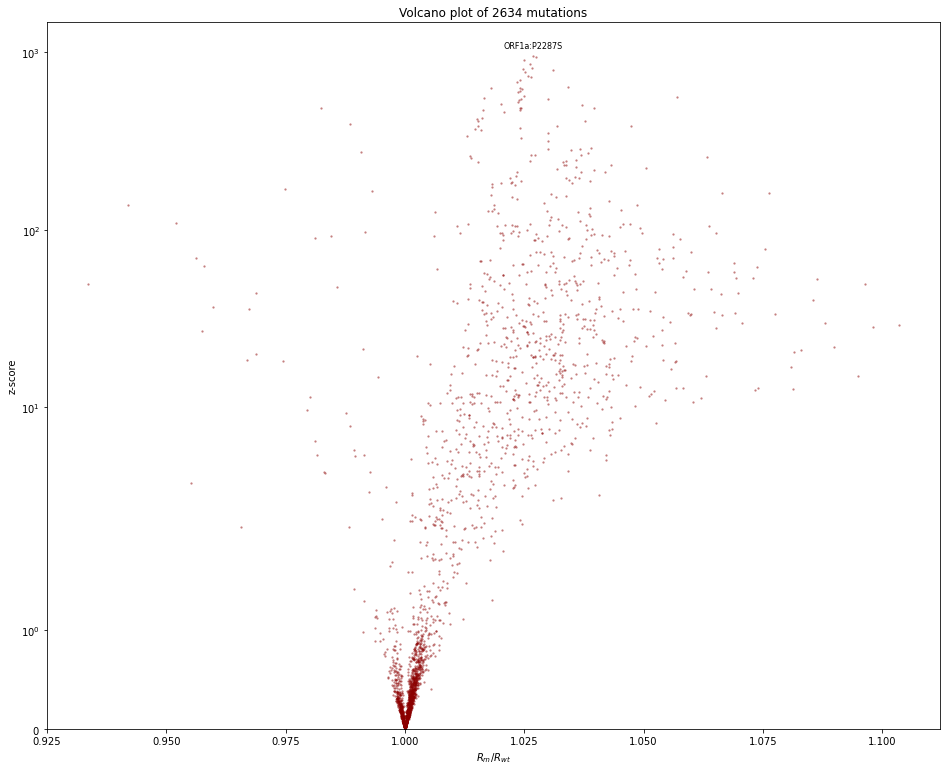

In [42]:
plot_volcano(guide)

##### Next let’s create a custom guide for part of the model, just the rate and init parts. Since we’ll want to use this with reparametrizers, we’ll make the guide use the auxiliary latent variables created by poutine.reparam, rather than the original rate and init variables. Let’s see what these variables are named:

In [43]:
for name, site in poutine.trace(reparam_model).get_trace(data_set).iter_stochastic_nodes():
    print(name)

rate_scale
init_scale
mutation
coef
strain
place
rate_decentered
init_decentered


##### It looks like these new auxiliary variables are called rate_decentered and init_decentered.

In [51]:
def local_guide(data_set):
    T, P, S = data_set["counts"].shape
    r_loc = pyro.param("rate_decentered_loc", lambda: torch.zeros(P, S))
    i_loc = pyro.param("init_decentered_loc", lambda: torch.zeros(P, S))

    skew = pyro.param("skew", lambda: torch.zeros(P, S)) # allow for correlation
    r_scale = pyro.param("rate_decentered_scale", lambda: torch.ones(P, S), constraint=constraints.softplus_positive)
    i_scale = pyro.param("init_decentered_scale", lambda: torch.ones(P, S), constraint=constraints.softplus_positive)

    # Sample local variables inside plates.
    # Note plates are already created by the main guide, so we'll
    # use the existing plates rather than calling pyro.plate(...).

    with guide.plates["place"], guide.plates["strain"]:
        samples = {}
        samples["rate_decentered"] = pyro.sample(
            "rate_decentered", dist.Normal(r_loc, r_scale)
        )
        i_loc = i_loc + skew * samples["rate_decentered"]
        samples["init_decentered"] = pyro.sample(
        "init_decentered", dist.Normal(i_loc, i_scale)
    )

found 538452 latent variables and 1468870 learnable parameters
step    0 loss= 4916.49
step  100 loss= 29.9872
step  200 loss= 19.2541
step  300 loss= 14.9839
step  400 loss= 12.7644
step  500 loss= 11.7035
step  600 loss= 11.0433
step  700 loss= 10.6637
step  800 loss= 10.3495
step  900 loss= 10.126
step 1000 loss= 10.0074
CPU times: user 6min 1s, sys: 14.4 s, total: 6min 15s
Wall time: 1min 37s


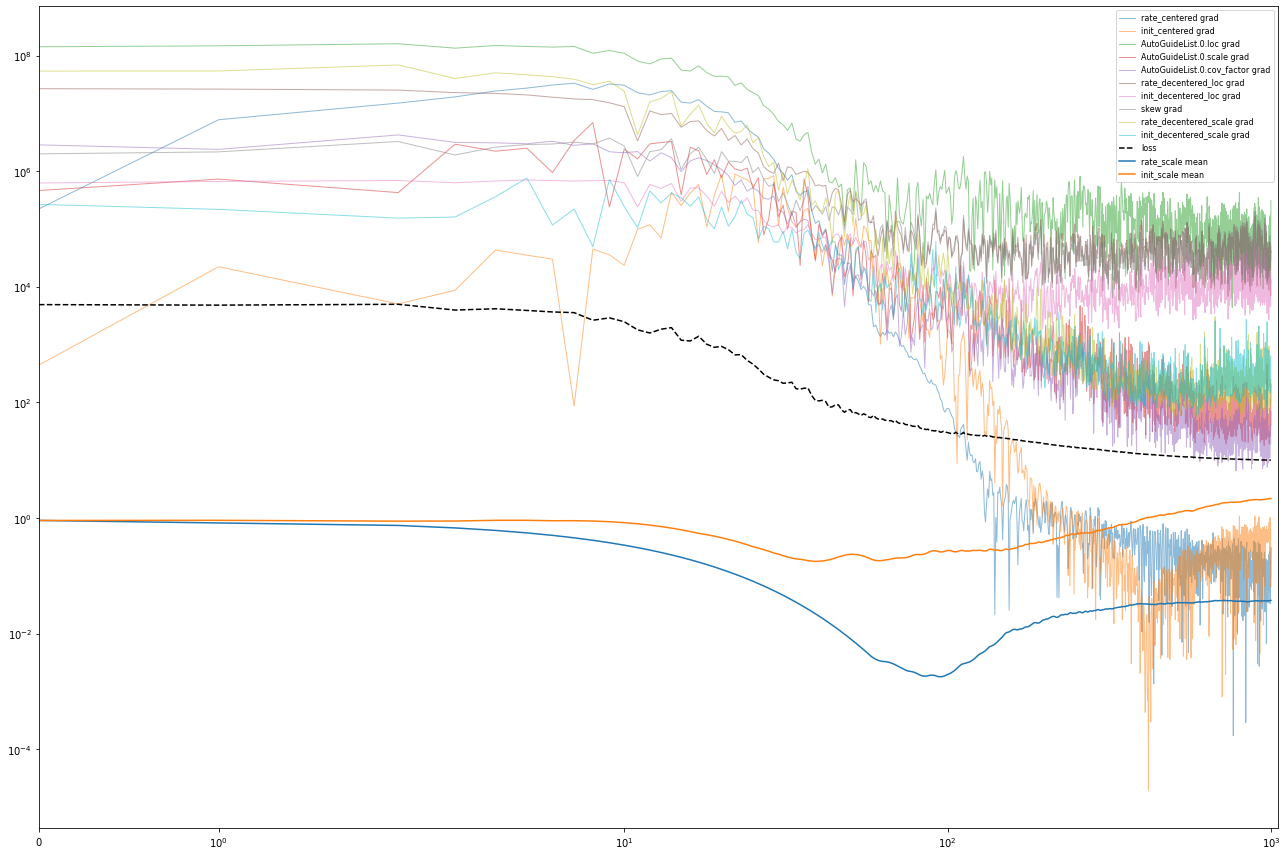

In [52]:
%%time
reparam_model = poutine.reparam(
    model,
    {
        "rate": LocScaleReparam(),
        "init": LocScaleReparam()
    }
)

guide = AutoGuideList(reparam_model)

local_vars = ["rate_decentered", "init_decentered"]

guide.add(
    AutoLowRankMultivariateNormal(
        poutine.block(reparam_model, hide=local_vars),
        init_loc_fn = init_loc_fn,
        init_scale = 0.01
    )
)

guide.add(local_guide)

fit_svi(reparam_model, guide, lr=0.1)

In [53]:
evaluate(model, guide)

{'MAE (global)': 0.6879233121871948,
 'MAE (USA / Massachusetts)': 1.5889785289764404}

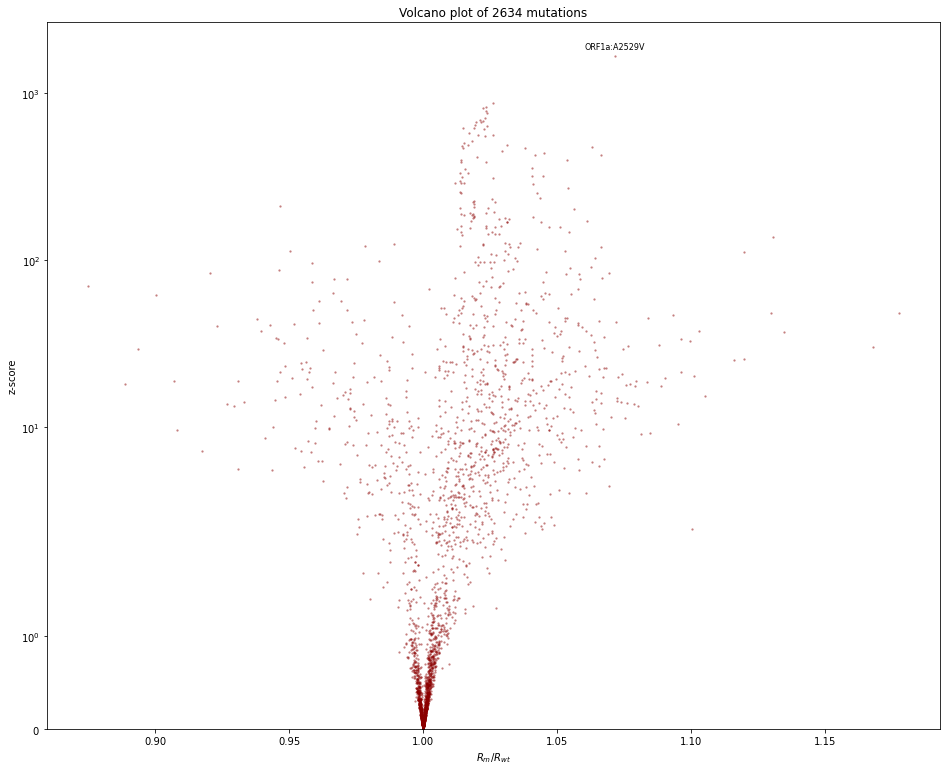

In [54]:
plot_volcano(guide)